In [1]:
import feather 
import pandas as pd
import numpy as np


In [50]:
train = feather.read_dataframe("../data/input/tr_best.feather")
test = feather.read_dataframe("../data/input/te_best.feather")
y = train["Score"]
del train["Score"]
del train["index"],test["index"],test["ID"]

In [8]:

import json
import numpy as np
with open('../configs/Kbest_FE.json') as f:
    df = json.load(f)
fl_score = np.array(df["kbest_feature"]["float"])
int_score = np.array(df["kbest_feature"]["int"])
cate_score = np.array(df["kbest_feature"]["cate"])

In [51]:
data = train.append(test)
c = [i for i in data.columns if len(data[i].unique()) > 2]
cc = [i for i in data.columns if len(data[i].unique()) == 2]
num_data = data[c]
cate_data = data[cc]

In [11]:
import multiprocessing as mp
from tqdm import tqdm
def get_dict(data):
    h_dict = {}
    s = min(data)
    #n_h = 5 if data.var() < 1 else 10
    n_h = int(1+np.log2(27463)) - 5
    rang = (max(data) - s)/n_h
    for i in range(n_h+1):
        h_dict[s] = i
        s += rang
    return h_dict
def func(data):
    a = get_dict(data)
    return list(map(lambda i : a[list(a.keys())[np.argmin(abs(np.array(list(a.keys())) - i))]],data))
def hierarical_transform(data):
    new = pd.DataFrame()
    with mp.Pool(4) as pool:
        imap = pool.imap(func, data.values.T)
        result = list(tqdm(imap, total = len(data.columns)))
    new = pd.DataFrame(np.array(result).T, columns = [f"{c}_h" for c in data.columns])
    return new
h_t = hierarical_transform(pd.concat([tr,te],axis=0))


NameError: name 'tr' is not defined

In [17]:

def hierarical(data):
    h_t = pd.DataFrame()
    for i in data.columns:
        h_t[f"{i}_h"] = pd.cut(data[i],bins=15,labels= False)
    return h_t

num_data = df_concat([fl_data,int_data])
h_t = hierarical(num_data)

In [123]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

#num_data =  df_concat([hist_int,np.round(dens_int,4),hist_fl,np.round(dens_fl,4)])
#num_data = df_concat([fl_data, FE_f,])
#num_data = df_concat([int_data, FE_i,])
#num_data = df_concat([cate_data, FE_c,FE10_c])

stdsc = StandardScaler()
#tr,te =num_data.iloc[:13731,:],num_data.iloc[13731:,:]
#tr,te = tr_lda,te_lda
#tr_std= stdsc.fit_transform(tr)
# 訓練用データを基準にテストデータも標準化
#te_std = stdsc.transform(te)

def PCA_feature(data,typ):

    n_components = 50
    pca = PCA(n_components=n_components)
    X_train,X_test = data.iloc[:13731,:],data.iloc[13731:,:]
    x_train_projected = pca.fit_transform(X_train)
    x_test_projected = pca.transform(X_test)
    new1 = pd.DataFrame()
    new2 = pd.DataFrame()
    for npca in range(0, n_components):
        new1[f'{typ}frq_PCA_'+str(npca+1)] = x_train_projected[:, npca]
        new2[f'{typ}frq_PCA_'+str(npca+1)] = x_test_projected[:, npca]
    new = new1.append(new2)
    return new
#tr_frq,te_frq =frq.iloc[:13731,:],frq.iloc[13731:,:]


In [124]:
#fl_pca = PCA_feature(fl_frq,"float") # 14
#int_pca = PCA_feature(int_frq,"int") # 30
#cate_pca = PCA_feature(cate_frq,"cate") #10
h_pca = PCA_feature(h_frq,"hi") 

0.6875065796298425

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


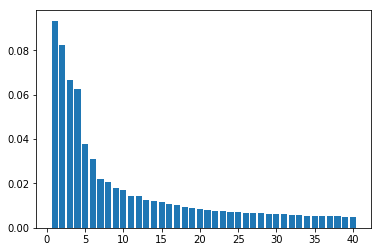

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 40)

pca.fit(h_frq.iloc[:13731,:])
import matplotlib.pyplot as plt
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

In [16]:
def df_concat(flist):
    add_columns = flist[0].columns.values.tolist()
    add_df = flist[0].values
    for i in flist[1:]:
        add_columns += i.columns.values.tolist()
        add_df = np.c_[add_df,i.values]
    return pd.DataFrame(add_df,columns=add_columns)



In [18]:
def freq_encoing(data):
    new = pd.DataFrame()
    l = len(data)
    for i in data.columns:
        tmp = data.groupby(i).size()
        tmp = tmp/l
        new[f"{i}_FreqEnc_"] = data[i].map(tmp)
        
    return new
fl_frq = freq_encoing(fl_data)
int_frq = freq_encoing(int_data)
cate_frq = freq_encoing(cate_data)
#te_frq = freq_encoing(te_t)

In [23]:
h_frq = freq_encoing(h_t)

In [31]:
frq_data = df_concat([fl_frq,int_frq,cate_frq,h_frq])

In [141]:
frq_pca_data = df_concat([h_t, h_frq])

In [60]:
#new = pd.DataFrame()
from tqdm import tqdm

    #new.loc[i,"x>0.5"] = np.where(frq_data.iloc[i,:] > 0.5,1,0).sum()
    #new.loc[i,"x>0.1"] = np.where(frq_data.iloc[i,:] > 0.1,1,0).sum()
for i in tqdm(range(len(frq_data[:]))):
    new.loc[i,"x>0.5"] = np.where(frq_data.iloc[i,:] > 0.5,1,0).sum()
    new.loc[i,"x>0.1"] = np.where(frq_data.iloc[i,:] > 0.1,1,0).sum()
    new.loc[i,f"prob_sum"] = frq_data.iloc[i,:].sum()
    new.loc[i,f"prob_max"] = frq_data.iloc[i,:].max()
    new.loc[i,f"prob_min"] = frq_data.iloc[i,:].min()
    new.loc[i,f"prob_var"] = frq_data.iloc[i,:].var()
    new.loc[i,f"prob_std"] = frq_data.iloc[i,:].std()
    new.loc[i,f"prob_skew"] = frq_data.iloc[i,:].skew()
    new.loc[i,f"prob_skew"] = frq_data.iloc[i,:].kurtosis()

100%|██████████| 27463/27463 [02:17<00:00, 199.24it/s]


In [82]:
frq_tr = feather.read_dataframe("../data/input/tr_best_prob.feather")
frq_te = feather.read_dataframe("../data/input/te_best_prob.feather")
frq = frq_tr.append(frq_te)
fl_pca = frq.loc[:,"fl_PCA_1":"fl_PCA_14"]
int_pca  =frq.loc[:,"int_PCA_1":"int_PCA_11"]
cate_pca = frq.loc[:,"cate_PCA_1":"cate_PCA_30"]
d = df_concat([fl_pca,int_pca,cate_pca])
n = len(train)
tr_pca,te_pca = d.iloc[:n,:],d.iloc[n:,:]

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [77]:
tr_pca,te_pca = cate_pca.iloc[:n,:],cate_pca.iloc[n:,:]

In [88]:
tr_t,te_t = h_t.iloc[:n,:],h_t.iloc[n:,:]

In [79]:
tr_f,te_f = frq.iloc[:n,:],frq.iloc[n:,:]

In [142]:
data = df_concat([train.append(test),frq_pca_data,new])
#tr_submit = df_concat([tr,cate_tr,pca1])
#te_submit = df_concat([te,cate_te,pca2])

In [135]:

tr_submit = df_concat([tr,cate_tr,pca1])
te_submit = df_concat([te,cate_te,pca2])

NameError: name 'tr' is not defined

In [143]:
n = len(train)
tr_submit ,te_submit = data.iloc[:n,:],data.iloc[n:,:]

In [144]:
tr_submit.reset_index(inplace = True)
te_submit.reset_index(inplace = True)

In [145]:
del tr_submit["index"],te_submit["index"]

In [146]:
tr_submit.to_feather("../data/input/tr_frq_h.feather")
te_submit.to_feather("../data/input/te_frq_h.feather")

In [86]:
new = pd.DataFrame()
data = tr.append(te)
for i in frq.columns:
    new[f"{i}_rank"]=frq[i].rank()
    

In [89]:
n = len(train)
tr_r,te_r = new.iloc[:n,:],new.iloc[n:,:]
tr_f,te_f = frq.iloc[:n,:],frq.iloc[n:,:]
tr_submit = df_concat([tr,cate_tr,tr_r,tr_f,tr_t])
te_submit = df_concat([te,cate_te,te_r,te_f,te_t])

In [90]:
tr_submit["Score"] = y
tr_submit.to_feather("../data/input/tr_r.feather")
te_submit.to_feather("../data/input/te_r.feather")

ModuleNotFoundError: No module named 'umap'

In [106]:
poly = pd.DataFrame()
data = tr.append(te)
for i in tr.columns:
    poly[f"dot_{i}_col88"] = data["col88"]*data[i]
    poly[f"mod_{i}_col88"] =  data["col88"].map(lambda x : 0 if int(x) == 0 else x/data[i])


KeyboardInterrupt: 

In [59]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
tr,te = new.iloc[:len(train),:],new.iloc[len(train):,:]
std_tr = std.fit_transform(tr)
std_te = std.transform(te)

In [57]:
def yeo(data):
    new = pd.DataFrame()
    for i in data.columns:
        new[i] = data[i].map(lambda x : np.log1p(x) if x > 0 else -np.log1p(-x))
    return new
a = num_data.copy()
new = yeo(a)

In [13]:
from scipy.special import erfinv
from tqdm import tqdm
def rank_gauss(df):
    for c in tqdm(df.columns):
        series = df[c].rank()
        M = series.max()
        m = series.min() 
        series = (series-m)/(M-m)
        series = series - series.mean()
        series = series.apply(erfinv) 
        df[c] = series
    return df



In [53]:
num_train,num_test = num_data.iloc[:len(train),:],num_data.iloc[len(train):,:]
rank_tr= rank_gauss(num_train)
rank_te= rank_gauss(num_test)

  0%|          | 0/444 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 444/444 [00:40<00:00, 10.75it/s]


In [62]:
std_tr = pd.DataFrame(std_tr,columns=num_data.columns)
std_te = pd.DataFrame(std_te,columns=num_data.columns)

In [63]:
#cate_tr,cate_te = cate_data.iloc[:len(train),:],cate_data.iloc[len(train):,:]
t = df_concat([std_tr,cate_tr])
tt = df_concat([std_te,cate_te])


In [64]:
t.to_feather("../data/input/stack/train_yeostd.feather")
tt.to_feather("../data/input/stack/test_yeostd.feather")

In [23]:
len(t)

13731

In [31]:
n = len(train)
h_t = feather.read_dataframe("../features/cut.feather")

tr_t,te_t = h_t.iloc[:n,:],h_t.iloc[n:,:]

In [32]:
import sklearn.base
from  bhtsne import tsne
import numpy as np



# 訓練用データを基準にテストデータも標準化


y = tsne(h_t.astype("float64"),rand_seed=1103,dimensions=3,perplexity=30)

In [1]:
train

NameError: name 'train' is not defined

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


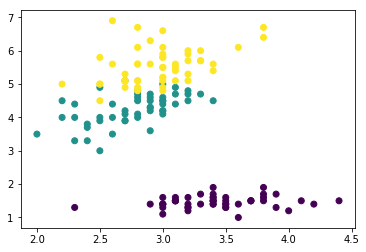

In [42]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
data = load_iris()
x = data.data
y = data.target
plt.scatter(x[:,1],x[:,2],c = y)

In [147]:
umap = feather.read_dataframe("../features/DAE_umap.feather")

In [150]:
tr,te = umap.iloc[:len(train),:],umap.iloc[len(train):,:]

In [155]:
tt = df_concat([train,tr])
t = df_concat([test,te])

In [156]:
tt.to_feather("../data/input/train_umap.feather")
t.to_feather("../data/input/test_umap.feather")